In [7]:
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm

In [8]:
path = Path("Dataset_TP3")
videos_paths = [p for p in path.iterdir() if p.is_file()]

videos: dict[Path, cv2.VideoCapture] = {}
for file in videos_paths:
    vid = cv2.VideoCapture(file)
    if not vid.isOpened():
        print("Error: Could not open video.")
        continue
    videos[file] = vid
    break

In [ ]:
interactive = False
r = 50

edges = {}

print(f"Processing {len(videos)} videos")
for video_path in videos:
    video = videos[video_path]
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    distances = None
    edges_lst = []  # Moved OUTSIDE the frame loop

    for frame_idx in tqdm(range(frame_count)):
        ret, frame = video.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

        # Dilatation des gradients en utilisant un noyau circulaire
        if distances is None:
            h, w = sobel_x.shape
            center_y, center_x = h // 2, w // 2
            y, x = np.ogrid[:h, :w]
            distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
            max_dist = np.max(distances)
            bin_size = max_dist / r

        sobel_x_reshaped = np.zeros(r)
        sobel_y_reshaped = np.zeros(r)

        for i in range(r):
            mask = (distances >= i * bin_size) & (distances < (i + 1) * bin_size)
            if np.any(mask):
                sobel_x_reshaped[i] = np.mean(np.abs(sobel_x[mask]))
                sobel_y_reshaped[i] = np.mean(np.abs(sobel_y[mask]))

        edges_lst.append((sobel_x, sobel_y, sobel_x_reshaped, sobel_y_reshaped))

        if interactive:
            magnitude = cv2.magnitude(sobel_x, sobel_y)
            edged = cv2.convertScaleAbs(magnitude)
            cv2.imshow("Edged Frame", edged)
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord("q"):
                break

    edges[video_path] = edges_lst

Processing 1 videos


 37%|███▋      | 1861/5047 [01:06<2:55:05,  3.30s/it]

Video: Dataset_TP3/combat_cuts.mp4
Mean ρin: nan, Mean ρout: nan


/home/nathan/Documents/PolyTechnique-Montreal/Trimestre_7/INF8770/Tp/Tp3/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathan/Documents/PolyTechnique-Montreal/Trimestre_7/INF8770/Tp/Tp3/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


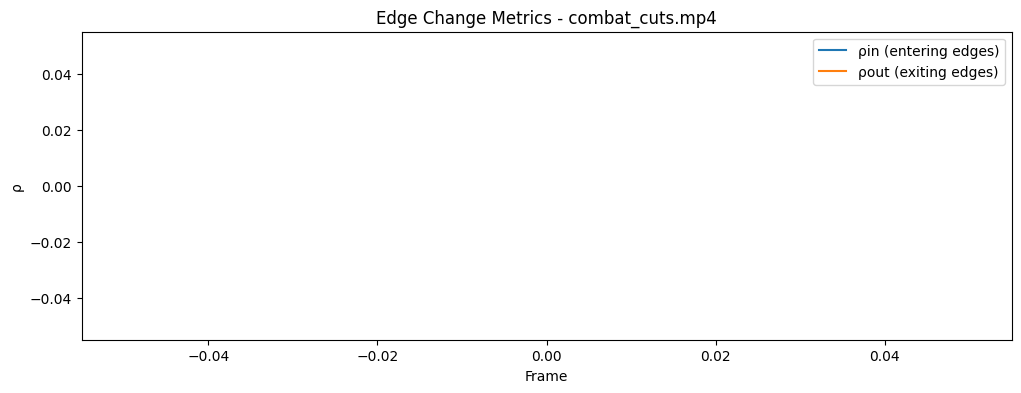

In [5]:
# Cell to calculate ρin and ρout between consecutive frames


def compute_edge_map(sobel_x, sobel_y, threshold=30):
    """Compute binary edge map from Sobel gradients"""
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    return (magnitude > threshold).astype(np.float64)


def dilate_edges(edge_map, kernel_size=3):
    """Dilate edge map"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    return cv2.dilate(edge_map.astype(np.uint8), kernel).astype(np.float64)


for video_name in edges:
    edges_lst = edges[video_name]
    rho_in_list = []
    rho_out_list = []

    for t in range(len(edges_lst) - 1):
        sobel_x_t, sobel_y_t, _, _ = edges_lst[t]
        sobel_x_t1, sobel_y_t1, _, _ = edges_lst[t + 1]

        # Edge maps at time t and t+1
        E_t = compute_edge_map(sobel_x_t, sobel_y_t)
        E_t1 = compute_edge_map(sobel_x_t1, sobel_y_t1)

        # Dilated edge maps
        D_t1 = dilate_edges(E_t1)
        D_t = dilate_edges(E_t)

        # ρin: entering edges (new edges in frame t+1)
        # ρin = 1 - (Σ D(x,y,t) * E(x,y,t+1)) / (Σ E(x,y,t+1))
        sum_E_t1 = np.sum(E_t1)
        if sum_E_t1 > 0:
            rho_in = 1 - np.sum(D_t * E_t1) / sum_E_t1
        else:
            rho_in = 0

        # ρout: exiting edges (edges leaving from frame t)
        # ρout = 1 - (Σ E(x,y,t) * D(x,y,t+1)) / (Σ E(x,y,t))
        sum_E_t = np.sum(E_t)
        if sum_E_t > 0:
            rho_out = 1 - np.sum(E_t * D_t1) / sum_E_t
        else:
            rho_out = 0

        rho_in_list.append(rho_in)
        rho_out_list.append(rho_out)

    print(f"Video: {video_name}")
    print(
        f"Mean ρin: {np.mean(rho_in_list):.4f}, Mean ρout: {np.mean(rho_out_list):.4f}"
    )

    # Plot the metrics
    plt.figure(figsize=(12, 4))
    plt.plot(rho_in_list, label="ρin (entering edges)")
    plt.plot(rho_out_list, label="ρout (exiting edges)")
    plt.xlabel("Frame")
    plt.ylabel("ρ")
    plt.legend()
    plt.title(f"Edge Change Metrics - {video_name.name}")
    plt.show()